In [105]:
import networkx as nx
import numpy as np

In [106]:
def get_neighbor_opinion_distribution(G, node):
    count = {}
    for neigh in nx.neighbors(G, node):
        opinion = G.nodes[neigh]['opinion']
        count[opinion] = count.get(opinion, 0) + 1
    return count

In [107]:
def get_majority_opinion(G, node):
    """
    Calculate the majority opinion of the nodes, i.e., the opinion held by the largest 
    number of individuals among the neighbors of the node.
    """
    count = get_neighbor_opinion_distribution(G, node)
    max_count = 0
    maj_opinion = None
    for o, c in count.items():
        if c > max_count:
            maj_opinion = o
            max_count = c  
    return maj_opinion        

In [108]:
def rewire(G, node, phi):
    count = get_neighbor_opinion_distribution(G, node)
    min_opinion_count = min(count.values()) 
    candidate_removal_nodes = [ neigh for neigh in nx.neighbors(G, node) if 
                                count[G.nodes[neigh]['opinion']] == min_opinion_count and
                                G.degree[neigh] > 1 and
                                G.nodes[neigh]['opinion'] != G.nodes[node]['opinion']
                               ]
    if not candidate_removal_nodes:
        return
    neigh_remove = np.random.choice(candidate_removal_nodes)
    rule = np.random.binomial(1, phi)
    # rewire to neighbor of neighbors
    if rule == 1:
        neighbor_of_neighbors = { neigh_of_neigh 
                                for neigh in nx.neighbors(G, node) 
                                for neigh_of_neigh in nx.neighbors(G, neigh) 
                                if G.nodes[neigh_of_neigh]['opinion'] == G.nodes[node]['opinion']
                                }
        neighbor_of_neighbors.remove(node)
        if not neighbor_of_neighbors:
            return
        neigh_add = np.random.choice(list(neighbor_of_neighbors)) 
        G.add_edge(node, neigh_add)
    if rule == 0:
        candidates = [ person 
                       for person in nx.nodes(G)
                       if G.nodes[person]['opinion'] == G.nodes[node]['opinion']
                       if person not in nx.neighbors(G, node) 
                    ]   
        candidates.remove(node)
        if not candidates:
            return
        neigh_add = np.random.choice(candidates) 
        G.add_edge(node, neigh_add) 
    G.remove_edge(node, neigh_remove)    

In [109]:
class Simulation:
    def __init__(self, N=15, avg_degree=5, p=0.5, phi=0.5, G=3):
        self.N = N
        self.p = p
        self.phi = phi
        self.G = G
        self.time = 0
        self.graph = nx.gnp_random_graph(N, avg_degree/N)
        # Guarantee initial graph is connected
        i = 0
        while(not nx.is_connected(self.graph)):
            if i == 5:
                raise RuntimeError("Couldn't generate connected random graph.")
            else:   
               self.graph = nx.gnp_random_graph(N, avg_degree/N)
               i += 1            
        self.init_opinions()
    def init_opinions(self):
        """ 
        Set the opinion of all individuals in the graph. 
        All opinions are equally likely (uniform distribution).
        """
        opinions = {i: np.random.choice(self.G) for i in range(self.N)}
        nx.set_node_attributes(self.graph, opinions, 'opinion')
    def step(self):
        """ 
        One step of the simulation. Application of one of the rules to a single node. 
        """
        # choose between MA and MP according to the parameter p
        rule = np.random.binomial(1, self.p)
        # choose a random node to apply the rule to
        node = np.random.choice(nx.nodes(self.graph))
        # rule==1 -> Apply majority preference rule to node
        if rule == 1:
            maj_opinion = get_majority_opinion(self.graph, node)
            self.graph.nodes[node]['opinion'] = maj_opinion
        # rule==0 -> Apply minority avoidance rule to node
        else:  
           rewire(self.graph, node, self.phi) 
        self.time += 1
    def stop_condition(self):
        """
        When we reach the consensus state we can stop the simulation, i.e., when each individuals
        opinion agrees with the majority of its neighbors.
        """
        def agrees_with_majority(node):
            count = get_neighbor_opinion_distribution(self.graph, node)
            max_opinion_count = max(count.values()) 
            return count.get(self.graph.nodes[node]['opinion'], 0) == max_opinion_count
        return all(
                agrees_with_majority(node)
                for node in nx.nodes(self.graph)
             )
           

In [110]:
def draw(G):
    nx.draw(G, with_labels= True, node_color=list(nx.get_node_attributes(G, "opinion").values()))

[(0, 6), (0, 8), (0, 12), (0, 13), (0, 14), (1, 3), (1, 4), (1, 7), (1, 8), (1, 14), (2, 5), (2, 10), (3, 7), (3, 10), (3, 11), (3, 14), (4, 5), (4, 6), (4, 8), (4, 14), (5, 7), (5, 11), (7, 11), (7, 12), (8, 9), (8, 13), (10, 12)]
{0: 0, 1: 1, 2: 0, 3: 0, 4: 2, 5: 2, 6: 2, 7: 1, 8: 2, 9: 2, 10: 2, 11: 2, 12: 2, 13: 1, 14: 1}


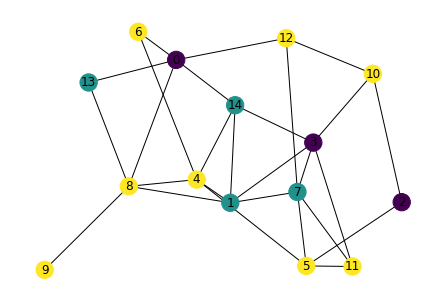

In [111]:
simul = Simulation(N=15, avg_degree=4)
G = simul.graph
print(simul.graph.edges)
print(nx.get_node_attributes(G, "opinion"))
draw(G)

{0: 0, 1: 1, 2: 0, 3: 1, 4: 2, 5: 2, 6: 2, 7: 1, 8: 2, 9: 2, 10: 2, 11: 2, 12: 2, 13: 1, 14: 1}


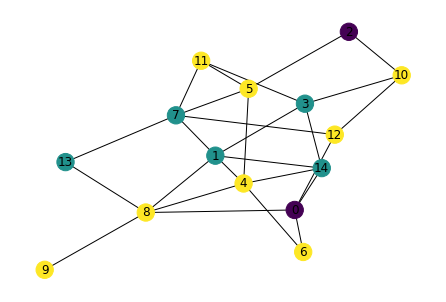

In [112]:
for _ in range(5) :
    simul.step()
print(nx.get_node_attributes(G, "opinion"))
draw(G)

25


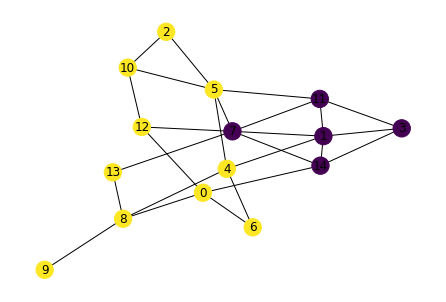

In [113]:
while(not simul.stop_condition()):
    simul.step()
draw(G)
print(simul.time)